# Implementation of semantic image segmentation. Source of the dataset: The Oxford-IIIT Pet Dataset
Omkar M Parkhi and Andrea Vedaldi and Andrew Zisserman and C. V. Jawahar
https://www.robots.ox.ac.uk/~vgg/data/pets/

### Imports

In [38]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

### Download data

In [39]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2023-10-06 05:12:30--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-10-06 05:12:31--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz.1’

images.tar.gz.1     100%[===================>] 755.23M  37.0MB/s    in 23s     

2023-10-06 05:12:54 (33.1 MB/s) - ‘images.tar.gz.1’ saved [791918971/791918971]

--2023-10-06 05:12:54--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox

### Create image and mask lists of paths

In [40]:
import os

# Define base directories
IMG_BASE_PATH = './images/'
MASK_BASE_PATH = './annotations/trimaps/'

# Initialize two lists to contain paths to images and masks
IMG_PATHS = []
MASK_PATHS = []

In [41]:
# Create all paths to images
for path in os.listdir(IMG_BASE_PATH):
  if path.endswith('.jpg'):
    IMG_PATHS.append(IMG_BASE_PATH + path)

# Create all paths to masks
for path in os.listdir(MASK_BASE_PATH):
  if path.endswith(".png") and not path.startswith("."):
    MASK_PATHS.append(MASK_BASE_PATH + path)

# Sort both lists
IMG_PATHS.sort()
MASK_PATHS.sort()

In [42]:
# Check if both lists have same length
print(len(IMG_PATHS), len(MASK_PATHS))

7390 7390


The segmentation mask takes 3 values:
* 1 (foreground)
* 2 (background)
* 3 (contour)

!!! NOTE !!! For some reason each mask pixel value is either:
* 0.00392157
* 0.00784314
* 0.01176471

Need to fix this before proceeding

In [43]:
def preprocess_mask(path):
  '''
  Utility function to preprocess mask before displaying it. Since each pixel has
  value 1, 2 or 3, we need to subtract 1 and multiply by 127, so that each pixel
  has either value 0 (black), 127 (gray), 254 (white)

  Args:
    path (string): path to mask

  Returns:
    Image of mask processed as described above
  '''
  img = plt.imread(path)
  # Fix pixel value issue (see comment above)
  pixel_values = sorted(np.unique(img))
  i = 0
  for value in pixel_values:
    img[img == value] = i
    i += 1
  # Scaling
  img *= 127
  return img.astype('uint8')


### Display random image and its corresponding mask

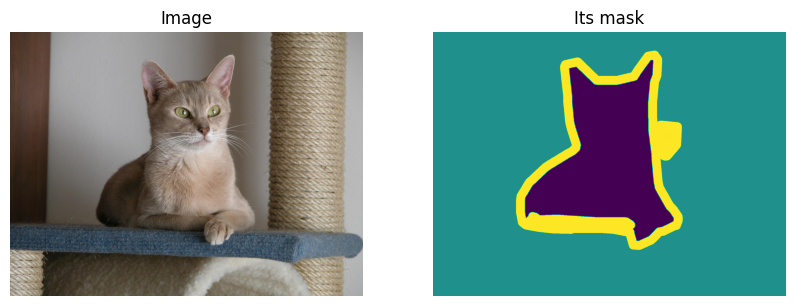

In [44]:
random_image = plt.imread(IMG_PATHS[42])
random_mask = preprocess_mask(MASK_PATHS[42])

fig, ax = plt.subplots(nrows = 1, ncols = 2)
fig.set_size_inches((10, 10))

ax[0].imshow(random_image)
ax[0].set_title('Image')
ax[0].axis('off')

ax[1].imshow(random_mask)
ax[1].set_title("Its mask")
ax[1].axis('off')

plt.show()

### Load dataset into memory

In [45]:
# Necessary imports
from tensorflow.keras.utils import load_img, img_to_array

In [46]:
# Definition of some constants
NUM_OF_SAMPLES = len(IMG_PATHS)
IMG_SIZE = (200, 200)

# Shuffle image and mask paths
random.Random(42).shuffle(IMG_PATHS)
random.Random(42).shuffle(MASK_PATHS)

In [64]:
# Utility functions to read image and mask in PIL format (needed for re-sizing images)
from PIL import Image

def path_to_image(path, img_size = IMG_SIZE):
  '''
  Utility function to read and return image given its path

  Args:
    path (string): path to image
    img_size (int, int): size of returned image

  Returns:
    image (ndarray): loaded image
  '''
  return img_to_array(load_img(path, target_size=IMG_SIZE))


def path_to_mask(path, img_size = IMG_SIZE):
  '''
  Utility function to read and return mask given its path

  Args:
    path (string): path to mask
    img_size (int, int): size of returned image

  Returns:
    mask (ndarray): loaded mask
  '''
  mask = img_to_array(load_img(path, target_size=IMG_SIZE, color_mode = 'grayscale'))
  mask = mask.astype("uint8") - 1
  return mask

In [65]:
mask = path_to_mask(MASK_PATHS[42])
img = path_to_image(IMG_PATHS[42])
# Check if pixel values are right
np.unique(mask)


array([0, 1, 2], dtype=uint8)

In [67]:
# Create empty arrays to store images and masks
IMG_DATASET = np.zeros(shape = (NUM_OF_SAMPLES, ) + IMG_SIZE + (3, ), dtype = 'float32')
MASK_DATASET = np.zeros(shape = (NUM_OF_SAMPLES, ) + IMG_SIZE + (1, ), dtype = 'uint8')

# Load data into corresponding arrays
for i in range(NUM_OF_SAMPLES):
  IMG_DATASET[i] = path_to_image(IMG_PATHS[i])
  MASK_DATASET[i] = path_to_mask(MASK_PATHS[i])

# Split data into training and validation sets
NUM_VAL_SAMPLES = 1000

TRAIN_IMG = IMG_DATASET[NUM_VAL_SAMPLES:]
TRAIN_MASK = MASK_DATASET[NUM_VAL_SAMPLES:]
VAL_IMG = IMG_DATASET[:NUM_VAL_SAMPLES]
VAL_MASK = MASK_DATASET[:NUM_VAL_SAMPLES]

### Build the model

The model is based on the U-Net architecture (https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/. It consists of two parts:
* The encoder - follows typical CNN architecture, where there are convolutional layers followed by pooling layers such that size of the processed image is reduced but the number of channels grows at each step.
* The decoder - uses transpose convolutions which halves the number of feature channels, while growing the height and width of the image, so that at the end we obtain original input image size.
Also, skip connections between encoder and decoder are used.

### Define building block of the encoder

In [91]:
def down_block(inputs, n_filters, strides = (1,1), dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block of the encoder

    Args:
      inputs (tensor): input tensor
      n_filters (int): number of filters for the convolutional layers
      strides (tuple of ints): optional stride for convolutional layers
      dropout_prob (float): dropout probability
      max_pooling (bool): whether to use max_pooling

    Returns:
      next_layer (tensor): output of CNN block
      skip_connection (tensor): skip connection to decoder block
    """

    # Forward propagate inputs through convolutional layers
    conv = tf.keras.layers.Conv2D(filters = n_filters,
                  kernel_size = 3,
                  activation='relu',
                  strides = (1,1),
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = tf.keras.layers.Conv2D(filters = n_filters,
                  kernel_size = 3,
                  strides = strides,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    # if dropout_prob > 0 add a dropout layer
    if dropout_prob > 0:
      conv = tf.keras.layers.Dropout(rate = dropout_prob)(conv)

    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
      next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
    else:
      next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

###Define building block of the encoder (same parameters as in down block)



In [69]:
def up_block(prev_layer_input, skip_connection_input, n_filters):
    """
    Convolutional upsampling block of the decoder

    Args:
      prev_layer_input (tensor): input from previous layer
      skip_connection_input (tensor): input from previous skip layer (from the encoder)
      n_filters (int): number of filters for the convolutional layers
    Returns:
      conv (tensor): output of this upsampling block
    """
    # Forward-propagate output of the previous layer
    up = tf.keras.layers.Conv2DTranspose(
                 filters = n_filters,
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Concatenate (at the channel axis) the previous output and the skip connection
    merge = tf.keras.layers.concatenate([up, skip_connection_input], axis=3)
    conv = tf.keras.layers.Conv2D(filters = n_filters,
                 kernel_size = 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = tf.keras.layers.Conv2D(filters = n_filters,
                 kernel_size = 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    return conv

### Building U-Net model - version 1 with max pooling layers for downsampling

In [70]:
# Define important constants
# Define number of filters for first block (this gets doubled every block)
N_FILTERS = 32
# Define number of classes of pixels (3 in this case)
NUM_CLASSES = 3

In [71]:
def build_model(n_filters = N_FILTERS, num_classes = NUM_CLASSES):
  # Define input layer
  inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
  # Rescaling inputs (could have been done at preprocessing step)
  x = tf.keras.layers.Rescaling(1./255)(inputs)

  # Passing data through first down block (notice that output is a tuple)
  down1 = down_block(inputs = inputs, n_filters = N_FILTERS, dropout_prob=0, max_pooling=True)
  # Passing data through second down block
  down2 = down_block(inputs = down1[0], n_filters = N_FILTERS*2, dropout_prob=0, max_pooling=True)
  # Passing data through third down block
  down3 = down_block(inputs = down2[0], n_filters = N_FILTERS*4, dropout_prob=0, max_pooling=True)
  # Passing data through fourth down block (no max pooling here)
  down4 = down_block(inputs = down3[0], n_filters = N_FILTERS*8, dropout_prob=0, max_pooling=False)

  # Passing data through first up block (notice parameters are in reverse order)
  up4 = up_block(prev_layer_input = down4[0], skip_connection_input = down3[1], n_filters = N_FILTERS*4)
  # Passing data through second up block
  up3 = up_block(prev_layer_input = up4, skip_connection_input = down2[1], n_filters = N_FILTERS*2)
  # Passing data through third up block
  up2 = up_block(prev_layer_input = up3, skip_connection_input = down1[1], n_filters = N_FILTERS)

  # Last convolutional layer sets channels = 3 as there are 3 classes of pixels (notice kernel size of 1)
  outputs = tf.keras.layers.Conv2D(filters = NUM_CLASSES, kernel_size = 1, padding = 'same')(up2)

  model = tf.keras.Model(inputs = inputs, outputs = outputs)
  return model

In [72]:
model1 = build_model()

### Show summary and plot model architecture

In [73]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 200, 200, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 200, 200, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

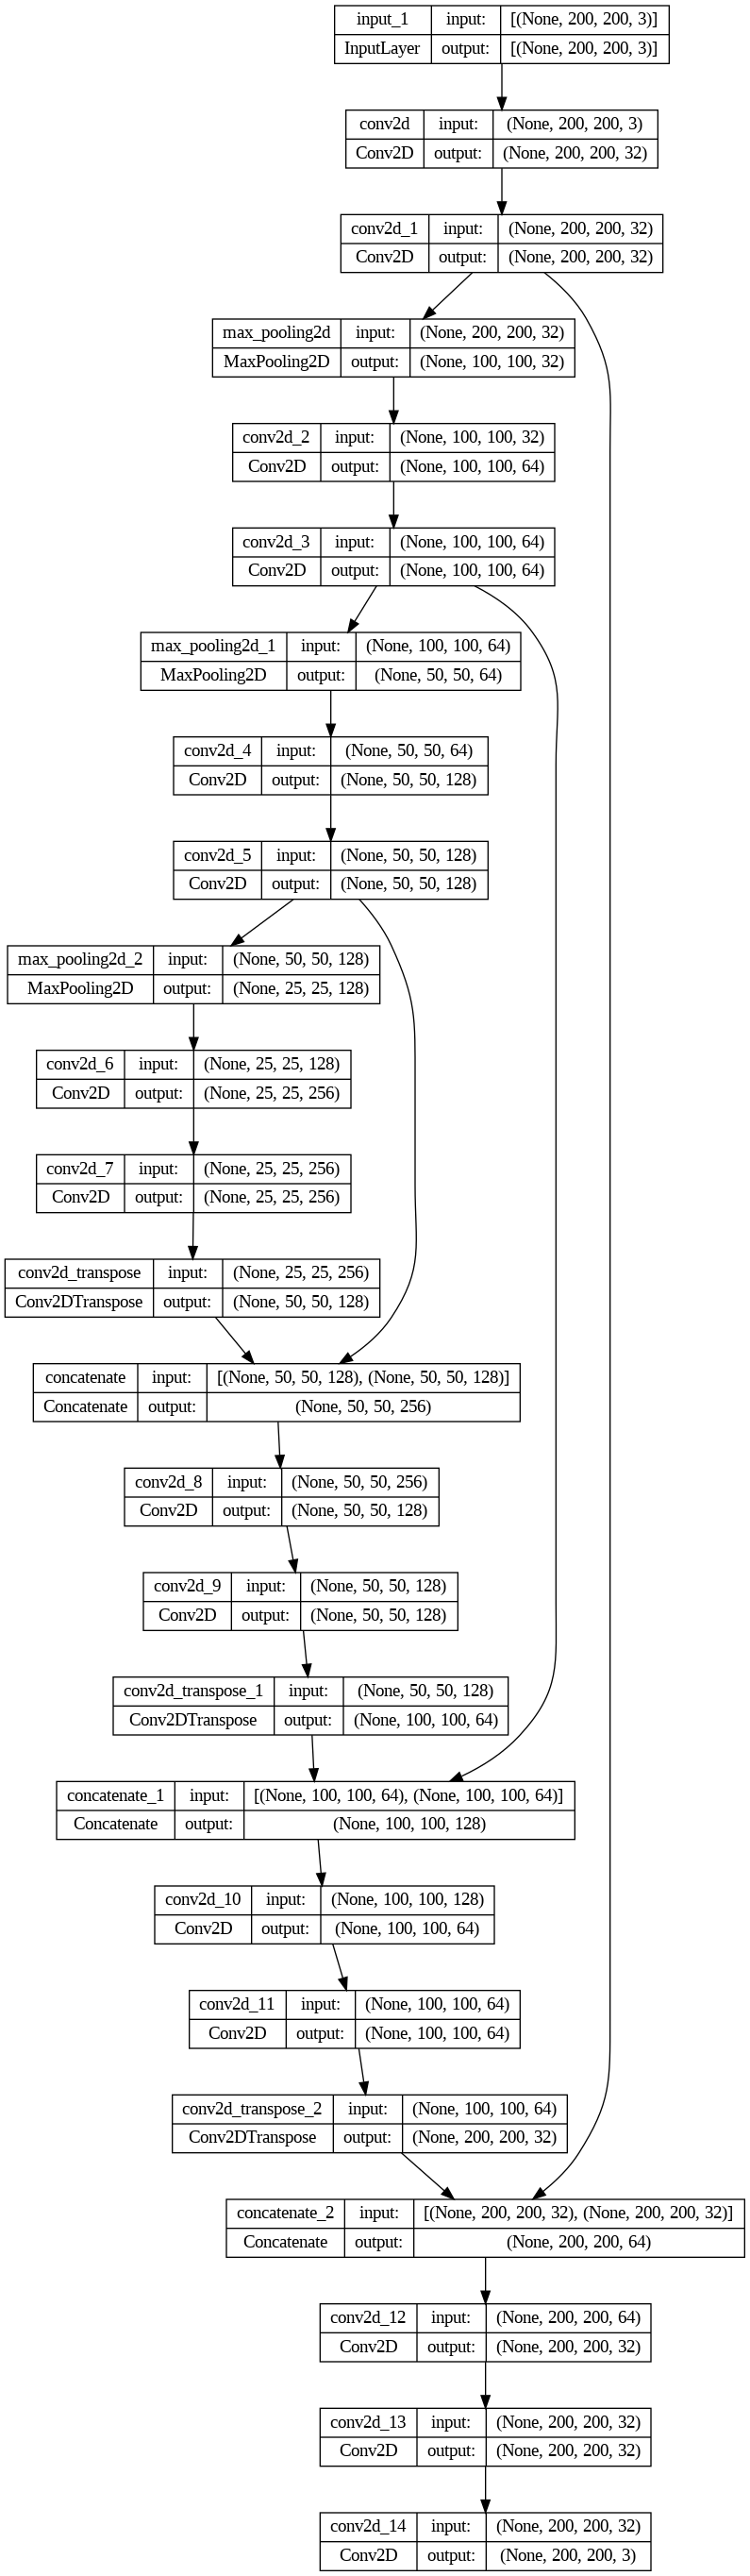

In [74]:
from tensorflow.keras.utils import plot_model

plot_model(model1, show_shapes = True)

In [75]:
### Compile and train model (notice from_logits parameter)
model1.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

history = model1.fit(x = TRAIN_IMG,
                    y = TRAIN_MASK,
                    epochs = 6,
                    validation_data = (VAL_IMG, VAL_MASK),
                    batch_size = 32)

Epoch 1/6
200/200 [==============================] - 100s 381ms/step - loss: 2.6131 - accuracy: 0.6084 - val_loss: 0.7503 - val_accuracy: 0.7061
Epoch 2/6
200/200 [==============================] - 69s 347ms/step - loss: 0.6925 - accuracy: 0.7317 - val_loss: 0.6750 - val_accuracy: 0.7386
Epoch 3/6
200/200 [==============================] - 71s 355ms/step - loss: 0.5701 - accuracy: 0.7818 - val_loss: 0.5679 - val_accuracy: 0.7791
Epoch 4/6
200/200 [==============================] - 69s 346ms/step - loss: 0.4924 - accuracy: 0.8116 - val_loss: 0.5227 - val_accuracy: 0.8068
Epoch 5/6
200/200 [==============================] - 72s 358ms/step - loss: 0.4487 - accuracy: 0.8278 - val_loss: 0.4301 - val_accuracy: 0.8374
Epoch 6/6
200/200 [==============================] - 69s 346ms/step - loss: 0.4266 - accuracy: 0.8366 - val_loss: 0.4066 - val_accuracy: 0.8447


### Plot training and validation loss

Since overfitting is not reached, there is still room for improvement (longer training)

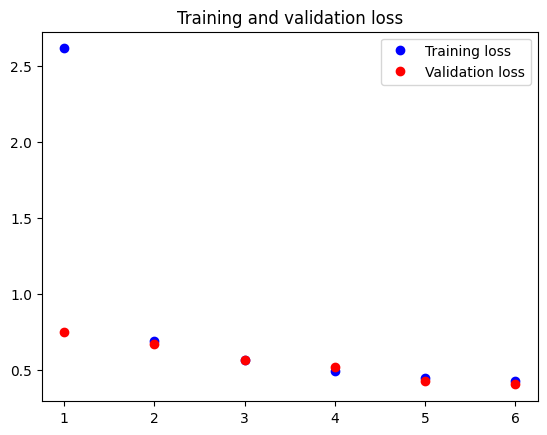

In [76]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "ro", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

### Make prediction

1/1 [==============================] - 0s 26ms/step


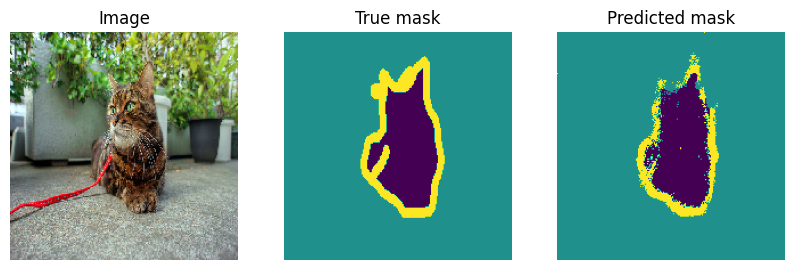

In [88]:
# Take random index from validation dataset
i = random.randint(a = 0, b = len(VAL_IMG))
# Take random test image
test_image = VAL_IMG[i]
# Pick true mask
true_mask = VAL_MASK[i]
# Preprocess mask for plotting
true_mask *= 127

# Predict and preprocess mask
predicted_mask = model1.predict(np.expand_dims(test_image, 0))[0]
predicted_mask = np.argmax(predicted_mask, axis=-1) # Picking most probable value of a pixel
predicted_mask *= 127

# Plotting
fig, ax = plt.subplots(nrows = 1, ncols = 3)
fig.set_size_inches((10, 10))

ax[0].imshow(test_image/255.)
ax[0].set_title('Image')
ax[0].axis('off')

ax[1].imshow(true_mask)
ax[1].set_title("True mask")
ax[1].axis('off')

ax[2].imshow(predicted_mask)
ax[2].set_title("Predicted mask")
ax[2].axis('off')

plt.show()
